In [ ]:
#default_exp csf

# csf
> Documentation for the Circular Separability Filter

In [ ]:
#export
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
from tqdm import tqdm

from skimage.feature import peak_local_max

In [ ]:

#export

def expand_dim_to_3(arr):
    if arr.ndim == 2:
        return np.expand_dims(arr, axis=-1)
    elif arr.ndim == 3:
        return arr
    else:
        raise ValueError()
        

def intensity_region_1(img, cx, cy, r, return_pixels=False):
    width = img.shape[0]
    height = img.shape[1]
    mask = np.zeros((width, height), np.uint8)

    circle_img = cv.circle(mask,(cx,cy),r, (255,255,255), thickness=-1)
    masked_data = cv.bitwise_and(img, img, mask=circle_img)[cy-r:cy+r+1, cx-r:cx+r+1]

    masked_data = expand_dim_to_3(masked_data)
    pixels = masked_data[masked_data.sum(axis=2)!=0]
    n_pixels = len(pixels)
        
    if return_pixels:
        return pixels 
    return pixels.mean(axis=0).mean(), n_pixels 
    
def intensity_region_2(img, cx, cy, r_in, r_out, return_pixels=False):

    assert r_in < r_out
    width = img.shape[0]
    height = img.shape[1]
    mask_r_out, mask_r_in = np.zeros((width, height), np.uint8), np.zeros((width, height), np.uint8)

    mask_r_out = cv.circle(mask_r_out,(cx,cy),r_out, (255,255,255), thickness=-1)
    mask_r_in = cv.circle(mask_r_in,(cx,cy),r_in, (255,255,255), thickness=-1)
    mask = cv.bitwise_and(mask_r_out, mask_r_out, mask=cv.bitwise_not(mask_r_in))
    
    masked_data = cv.bitwise_and(img, img, mask=mask)
    masked_data = expand_dim_to_3(masked_data)

    pixels = masked_data[masked_data.sum(axis=2)!=0]
    n_pixels = len(pixels)
    if return_pixels:
        return pixels 
    return pixels.mean(axis=0).mean(), n_pixels 


def seperability_filter(img, r_in, r_out):
    width, height = img.shape[:2]
    result = np.zeros((width, height))
    
    for x in tqdm(range(r_out, width-r_out)):
        for y in range(r_out, height-r_out):
            
            r1_pixels = intensity_region_1(img, x, y, r_in, True)
            r2_pixels = intensity_region_2(img, x, y, r_in, r_out, True)
            if r1_pixels.size==0 or r2_pixels.size==0:
                result[x, y] = 0
                continue
            
            r1_mean = r1_pixels.mean(axis=0, keepdims=True).T
            r2_mean = r2_pixels.mean(axis=0, keepdims=True).T
            
            n_r1 = len(r1_pixels)
            n_r2 = len(r2_pixels)
            
            n_overall = n_r1 + n_r2
            overall_mean = r1_mean * n_r1/n_overall + r2_mean * n_r2/n_overall
                        
            S_B = n_overall * (r1_mean - overall_mean).dot((r1_mean - overall_mean).T) + \
                n_overall * (r2_mean - overall_mean).dot((r2_mean - overall_mean).T)
            
            
            S_T = np.cov(np.concatenate([r1_pixels, r2_pixels]).T)
            if np.isnan(S_B).any() or np.isnan(S_T).any():
                result[x, y] = 0
            elif S_B.size==1:
                result[x,y] = S_B / S_T
            else:
                result[x,y] = np.trace(S_B) / np.trace(S_T)
                
    return result

In [ ]:
#export

class CircularSeparabilityFilter:
    def __init__(self, r_in, r_out):
        self.r_in = r_in
        self.r_out = r_out
        
    def __call__(self, img):
        return seperability_filter(img, self.r_in, self.r_out)
    
    def find_circles(self, img, num_circles=None):
        sepmap = seperability_filter(img, self.r_in, self.r_out)
        sepmap[np.isnan(sepmap)]=0
        peaks = peak_local_max(sepmap)
        
        if num_circles is None:
            return peaks
        else:
            return peaks[:num_circles] 
            

100%|██████████| 43/43 [00:00<00:00, 46.27it/s]


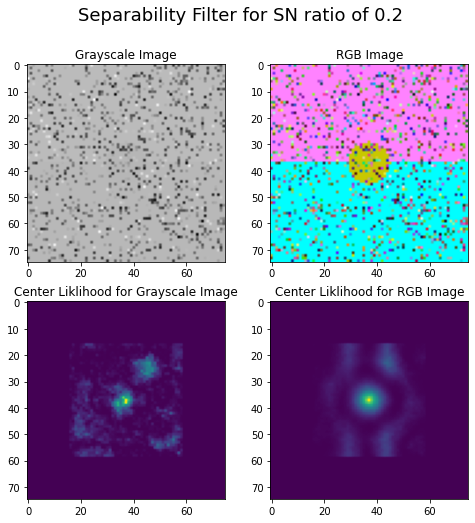

In [ ]:
#example

r_in, r_out = 8, 16
csf = CircularSeparabilityFilter(r_in, r_out)

size = 75
dummy_im = np.zeros((size, size, 3), np.uint8)
dummy_im[:size//2] = (255,130,255)
dummy_im[size//2:] = (255,255,0)

cv.circle(dummy_im, (size//2, size//2), 8, (0,200,200), thickness=-1)
density = 0.2

noise = np.ceil(scipy.sparse.rand(size, size, density).todense()).astype(np.uint8)
dummy_im +=  np.random.randint(0, 255, size=(size,size,3), dtype=np.uint8) * np.expand_dims(noise, axis=-1)

gray = cv.cvtColor(dummy_im, cv.COLOR_BGR2GRAY)
rgb = cv.cvtColor(dummy_im, cv.COLOR_BGR2RGB)

fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].imshow(gray, cmap='gray')
axs[0,0].set_title('Grayscale Image')

axs[0,1].imshow(rgb)
axs[0,1].set_title('RGB Image')

res = csf(gray)
axs[1,0].imshow(res)
axs[1,0].set_title('Center Liklihood for Grayscale Image')

res = csf(rgb)
axs[1,1].imshow(res)
axs[1,1].set_title('Center Liklihood for RGB Image')

fig.suptitle(f'Separability Filter for SN ratio of {density}', fontsize=18)
plt.show()